In [1]:
"""
Name: example.ipynb
Authors: Stephan Meighen-Berger
Example for the package
"""

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config

In [6]:
# Some example settings
# Scenario
config['scenario']['population size'] = 10
config['scenario']['duration'] = 10000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1e-3
config['scenario']['injection']['y range'] = [7.5, 12.5]
config['scenario']['light prop']: {
            "switch": True,
            "x_pos": 5.,
            "y_pos": 10.,
        }
# Organisms 
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 1.
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 40.,
    'y_length': 20.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 35.,
    'y_length': 5.,
    "offset": np.array([0., 7.5]),
}
config['geometry']["exclusion"]: {
    "function": "sphere",
    "radius": 0.3,
    "x_pos": 5.,
    "y_pos": 10.,
}
# Water
config['water']['model']['name'] = 'custom' # 'potential cylinder'
config['water']['model']['directory'] = "../data/current/cyclic/"
config['water']['model']['time step'] = 60
config['advanced']['starting step'] = 575

In [7]:
# Creating a fourth_day object
fd = Fourth_Day()

In [8]:
# Launching solver
fd.sim()

In [9]:
fd.statistics[-1]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,regeneration,is_emitting,emission_duration,encounter photons,shear photons,photons
0,Paraphyllina ransoni Russell,23.737200,15.799413,0.0,1.809164,0.001157,1.0000,False,7.733062,0.1,0.0001,False,0.0,0.0,0.0,0.0
1,Aeginura grimaldii Maas,13.400018,0.106750,0.0,3.196705,0.000995,1.0000,False,28.381538,0.1,0.0001,False,0.0,0.0,0.0,0.0
2,Praya dubia (Quoy and Gaimard),35.045292,9.514701,0.0,0.000000,0.001215,0.0437,False,14.656738,0.1,0.0001,False,-138.0,0.0,0.0,0.0
3,Nectopyramis natans (Bigelow),16.547096,7.499794,0.0,0.000000,0.001116,0.9010,False,18.142362,0.1,0.0001,False,-7.0,0.0,0.0,0.0
4,Periphyllopsis braueri Vanhoeffen,35.040074,10.715595,0.0,0.000000,0.001124,1.0000,False,28.261280,0.1,0.0001,False,-73.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,Craseoa lathetica Pugh and Harbison,4.853737,9.643825,0.0,0.000000,0.001616,1.0000,True,19.166167,0.1,0.0001,False,-82.0,0.0,0.0,0.0
561,Solmissus incisa (Fewkes),3.839692,7.881129,0.0,0.000000,0.001413,1.0000,True,5.647141,0.1,0.0001,False,-64.0,0.0,0.0,0.0
562,Chuniphyes multidentata Lens and van Riemsdijk,2.758823,11.949430,0.0,0.000000,0.000470,1.0000,True,17.652431,0.1,0.0001,False,-46.0,0.0,0.0,0.0
563,Craseoa lathetica Pugh and Harbison,1.679548,11.631462,0.0,0.000000,0.000998,1.0000,True,14.035604,0.1,0.0001,False,-28.0,0.0,0.0,0.0


In [10]:
# Plotting standards
std_size = 10.
fontsize = 20.
lw=3.
h_length=1.5

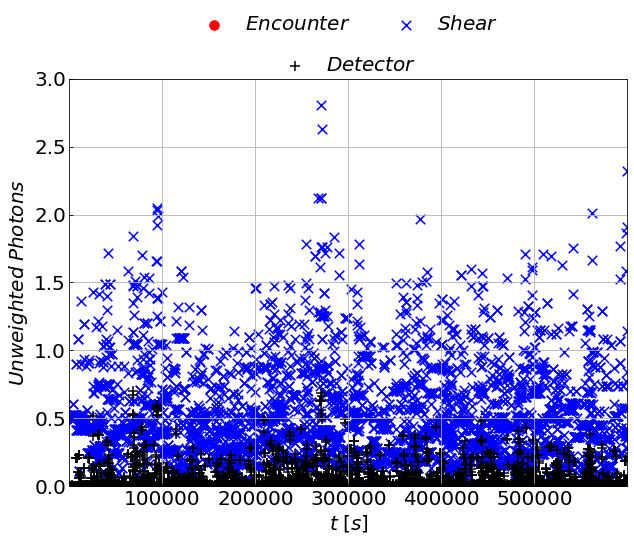

In [14]:
# Energy distributions
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
data_enc = np.array([np.sum(fd.statistics[i].loc[:, 'encounter photons'].values)
                     for i in range(len(fd.t))])
data_shear = np.array([np.sum(fd.statistics[i].loc[:, 'shear photons'].values)
                       for i in range(len(fd.t))])
data = np.array([np.sum(fd.statistics[i].loc[:, 'photons'].values)
                     for i in range(len(fd.t))])
ax1.scatter(fd.t,
            data_enc,
            s=lw*30, color='r', label=r'$Encounter$', marker="o")
ax1.scatter(fd.t,
            data_shear,
            s=lw*30, color='b', label=r'$Shear$', marker="x")
ax1.scatter(fd.t,
            fd.light_yields,
            s=lw*30, color='k', label=r'$Detector$', marker="+")
ax1.set_xlim(1e0, max(fd.t))
ax1.set_ylim(0., 3.)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$t\;[s]$', fontsize=fontsize)
ax1.set_ylabel(r'$Unweighted\;Photons$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h[:2],l[:2], loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
lgd2 = ax1.legend(h[2:],l[2:], loc=9, bbox_to_anchor=(0.5, +1.1),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.show()

In [15]:
figure.savefig(PICS + "MC_Example.png",
               bbox_inches='tight')